In [37]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and \
                           rule.replacements[0][0].isupper()

## Data importation

In [38]:
df_fixed = pd.read_csv('data/fixed_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_freq = df_freq.rename(columns={'User ID': 'userId'})

## Sentences reconstruction and feature extraction

In [39]:
# reconstruct users' sentences from the keycode in df_fixed

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_fixed = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_fixed.keyCode = df_fixed.keyCode.astype(str)

for i in range(len(df_fixed)):
    if i > 0 and (df_fixed.userId[i] != df_fixed.userId[i - 1] or df_fixed.emotionIndex[i] != df_fixed.emotionIndex[
        i - 1]):  #df_fixed._id[i][:-2] != df_fixed._id[i-1][:-2]:
        i_end = i - 1
        if len(text_fixed) == 62:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_start + ids_start[2] - 1]],
                             columns=['sentence', 'idx_start', 'idx_end']), ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[2], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        elif len(text_fixed) == 134 or len(text_fixed) == 190:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'Once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        else:
            if sentence[0].islower() and sentence[1].isupper():
                sentence = sentence.swapcase()
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_fixed.keyCode[i] == '\\b':  # delete key
        sentence = sentence[:max(0, len(sentence) - 1)]
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '\\u0014':  # caps lock key
        uppercase = not uppercase
        continue
    if df_fixed.keyCode[i] == '\\u0010' and not uppercase:  # shift key
        uppercase_tmp = True
        continue
    if df_fixed.keyCode[i] == '¼':  # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == 'ß':  # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¾':  # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '4    ':  # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '6    ':  # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¿':  # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_fixed.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_fixed.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_fixed.keyCode[i]

text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']),
                               ignore_index=True)

### Fixed text

In [40]:
# fixed text that users have been asked to write

gold_fixed = {
    'N': 'Once there was a cat and a mouse. Usually, cats eat mice, and mice run away from cats. But this cat and this mouse liked each other very much. They liked each other so much that they lived together.',
    'H': 'We can not help falling in love with cute and funny babies. Their beautiful and joyful laughter makes us happy.',
    'C': 'Beautiful nature and calm music are always relaxing. The soft sounds are so pleasant to listen to. Watching the superb nature calms our body and soul.',
    'S': 'The boy yells at his father to wake him up. But the father is dead. The poor boy is very sad. He realized that his father is gone forever.',
    'A': 'Jake has a horrible temper, especially when he drinks alcohol. He gets andgry and agressive when he is drunk. He savagely  beats and violeates his wife.'
}

In [41]:
# functions to extract features from the df_fixed table
df_fixed = df_fixed.drop(['D1U3', 'D1D3'], axis=1)
df_fixed.head()

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,NaN
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,NaN
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,NaN
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,NaN
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,NaN


In [42]:
def extract_editDistance_fixed(gold_fixed, emotion, sentence):
    return nltk.edit_distance(sentence, gold_fixed[emotion])

#this method is used to calculate the edit distance between two strings
#the edit distance is the number of characters that need to be substituted, inserted, or deleted, to transform one string into another


def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1

#this method is used to calculate the number of keystrokes


def extract_mean(val, start, end):
    return np.mean(val[start:end + 1])
#this method is used to calculate the mean of the values

def extract_std(val, start, end):
    return np.std(val[start:end + 1])
#this method is used to calculate the standard deviation of the values

def extract_answer(val, start, end):
    for i in range(start, end + 1):
        if val[i] != np.nan:
            return val[i]
    return np.nan
#this method is used to extract the answer from the values

In [43]:
# key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']
# 
# text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
# text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
# text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
# text_fixed['editDistance'] = text_fixed.apply(
#     lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
# text_fixed['nbKeystroke'] = text_fixed.apply(
#     lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
# text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)
# 
# for feat in key_features:
#     df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
#     text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                   axis=1)
#     text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                  axis=1)
# 
# text_fixed.head()


# altered due to ufunc error: UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

# Convert the key features columns to numeric, setting errors='coerce' to convert non-numeric values to NaN

key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']

for feat in key_features:
    df_fixed[feat] = pd.to_numeric(df_fixed[feat], errors='coerce')

    # Rest of your code
text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
text_fixed['editDistance'] = text_fixed.apply(
    lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
text_fixed['nbKeystroke'] = text_fixed.apply(
    lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)

# Apply the lambda function
for feat in key_features:
    df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                  axis=1)
    text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                 axis=1)

text_fixed.head()



,idx_start,idx_end,userId,emotionIndex,sentence,editDistance,nbKeystroke,answer,D1U1_mean,D1U1_std,D1U2_mean,D1U2_std,D1D2_mean,D1D2_std,U1D2_mean,U1D2_std,U1U2_mean,U1U2_std
0,0,282,100,N,"once there was a cat and a mouse. usually , ca...",26,283,NaN,96.074380,31.715592,884.215768,1157.264475,683.060284,1101.553201,694.609959,1157.337134,677.178571,1108.432937
1,283,422,100,H,We can not help falling in love with cute and ...,2,140,R,99.071429,22.182246,813.769784,701.131104,714.784173,699.459223,615.776978,696.222821,714.762590,697.865776
2,423,656,113,N,Once there was a cat and a mouse\u0010. Usaual...,23,234,NaN,88.440171,35.663291,449.802575,381.758170,361.309013,379.970339,272.832618,380.091995,361.326180,381.705475
3,657,840,113,C,Beautiful nature and calm music are always rel...,2,184,R,92.587571,51.886713,526.255682,613.476557,426.710383,601.426508,347.096591,614.503538,421.160221,614.552941
4,841,978,113,H,We can not help falling in love with cute and ...,2,138,R,92.086957,54.058138,443.934307,332.686657,352.138686,325.048838,260.189781,325.204406,351.985401,332.486627


[]

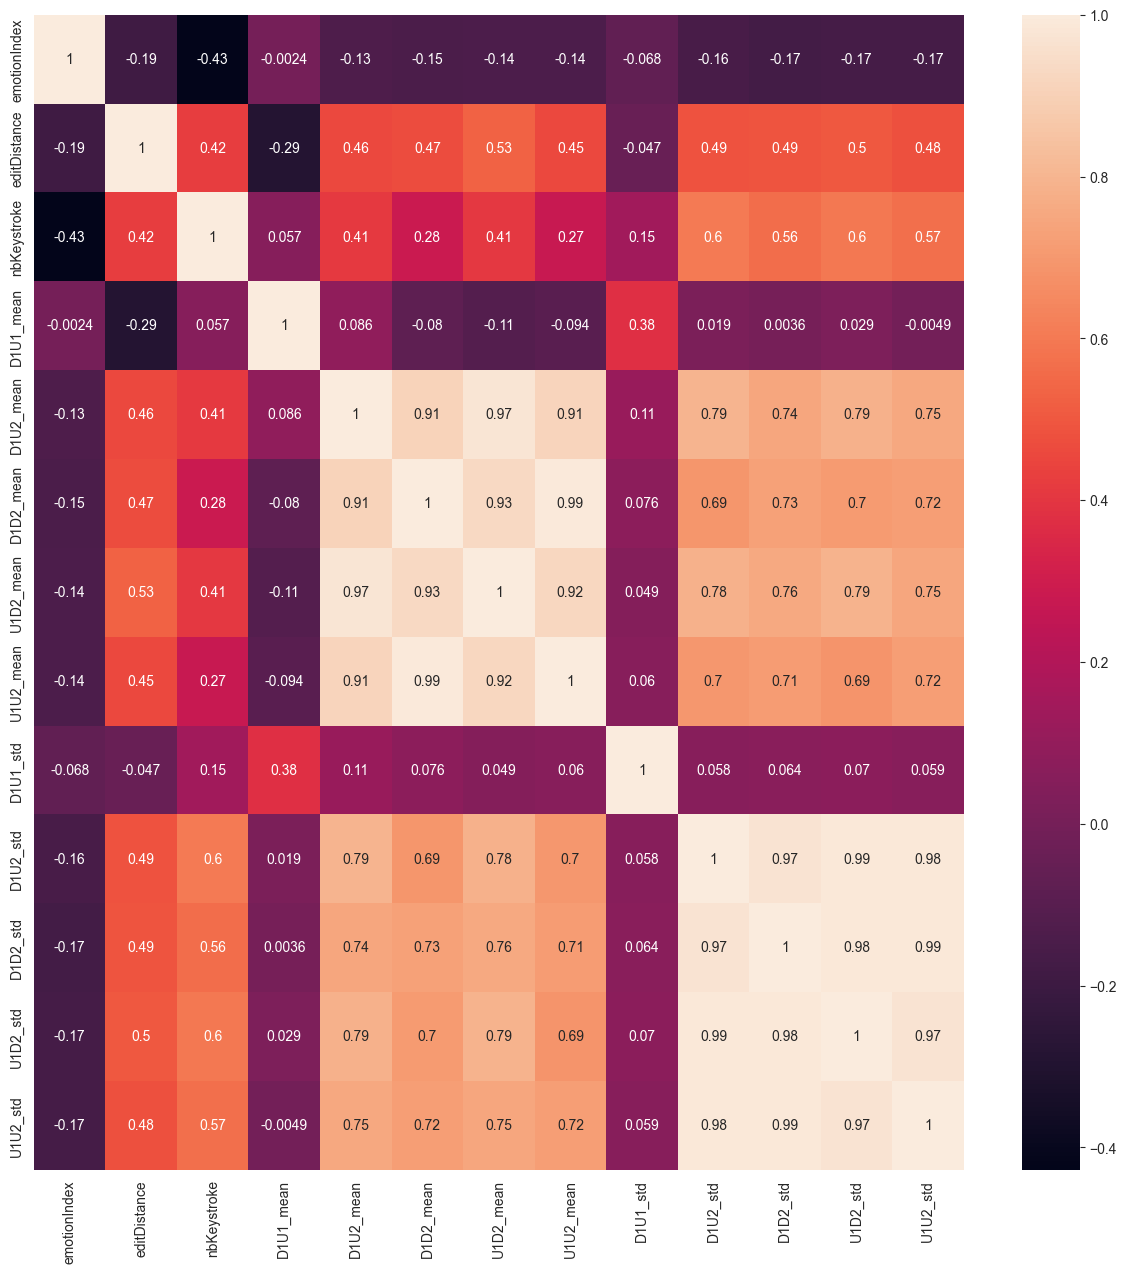

In [44]:
## correlation matrix

# Numeric columns of the dataset
text_fixed.emotionIndex = text_fixed.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
numeric_col = ['emotionIndex', 'editDistance', 'nbKeystroke'] + [col for col in text_fixed.columns if
                                                                 '_mean' in col] + [col for col in text_fixed.columns if
                                                                                    '_std' in col]

# Correlation Matrix formation
corr_matrix = text_fixed.loc[:, numeric_col].corr()
text_fixed.emotionIndex = text_fixed.emotionIndex.map({0: 'N', 1: 'H', 2: 'C', 3: 'S', 4: 'A'})

#Using heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_fixed with df_freq_fixed

In [45]:
# filter fixed-text experiments in df_freq
df_freq_fixed = df_freq[df_freq.textIndex == 'FI'].reset_index(drop=True)
#this method is used to reset the index of the DataFrame

In [46]:
# correction of expections to align df_freq_fixed and text_fixed tables
text_fixed.loc[44, 'userId'] = 94
tmp = text_fixed.loc[30]
text_fixed.loc[30] = text_fixed.loc[31]
text_fixed.loc[31] = tmp

In [47]:
# alignment of df_freq_fixed and text_fixed tables
text_fixed['text_index'] = -1
df_freq_fixed['text_index'] = -1
index = 0

i = 0
j = 0
while i < len(df_freq_fixed) and j < len(text_fixed):
    if df_freq_fixed.userId[i] == text_fixed.userId[j] and df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_fixed) - 1 and df_freq_fixed.userId[i] == text_fixed.userId[j + 1] and \
            df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j + 1]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j + 1, 'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_fixed) - 1 and df_freq_fixed.userId[i + 1] == text_fixed.userId[j] and \
            df_freq_fixed.emotionIndex[i + 1] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i + 1, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [48]:
# correction of expections to align df_freq_fixed and df_user tables
tmp = df_user.loc[92]
df_user.loc[92] = df_user.loc[91]
df_user.loc[91] = tmp

In [49]:
## alignment of df_freq_index and df_user tables
df_freq_fixed['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_fixed)):
    if i in [39, 59, 71, 145, 156, 159, 179, 235]:
        j += 1
    if j < len(df_user) and df_freq_fixed.userId[i] == df_user.userId[j]:
        df_freq_fixed.loc[i, 'user_index'] = j
        i += 1
    else:
        if j < len(df_user) - 1 and df_freq_fixed.userId[i] == df_user.userId[j + 1]:
            df_freq_fixed.loc[i, 'user_index'] = j + 1
            i += 1
            j += 1
        else:
            for k in range(1, 6):
                if df_freq_fixed.userId[i] == df_freq_fixed.userId[i - k]:
                    df_freq_fixed.loc[i, 'user_index'] = df_freq_fixed.loc[i - k, 'user_index']
                    break

In [50]:
# merge all tables
df_fixed_all = df_freq_fixed.join(text_fixed, on='text_index', how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_fixed_all = df_fixed_all.join(df_user.reset_index().rename(columns={'index': 'user_index'}), on='user_index',
                                 how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['user_index_right', 'userId_right'], axis=1)
df_fixed_all.head()

#df_fixed_all is the final DataFrame that contains all the information, that was built by joining the tables df_freq_fixed, text_fixed and df_user by using indexes that suit the sentences that were answered by the users

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,U1U2_mean,U1U2_std,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FI,N,8,1,192762.0,0,0,0,282,...,677.178571,1108.432937,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FI,H,11,0,99463.0,1,0,283,422,...,714.762590,697.865776,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FI,N,10,0,84265.0,2,1,423,656,...,361.326180,381.705475,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FI,C,7,0,78186.0,3,1,657,840,...,421.160221,614.552941,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FI,H,9,0,48354.0,4,1,841,978,...,351.985401,332.486627,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [52]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric,
                                   index=list(label_dictionary.values()),
                                   columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" % (metric_name, metric))

In [53]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}


def plot_confusion_matrix(confusion_matrix):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix,
                             index=[i for i in label_dictionary.values()],
                             columns=[i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

In [54]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    # Using Confusion Metrics to compute metrics
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')

        # Returning 
        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY,
                                                                                                           y_pred=clf.predict(
                                                                                                               dataX))

    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
                           "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
                           "Confusion Matrix": confusion_matrix}
    if show:
        show_metrics(performance_metrics)

    return performance_metrics

### Data pre-processing

In [55]:
data_fixed = df_fixed_all.loc[:, df_fixed_all.columns.difference(
    ['user_index', 'emotionIndex', 'userId', 'textIndex', 'text_index', 'idx_start', 'idx_end', 'sentence'])]
#loc method is a method that takes only index labels and returns the rows of the dataframe
label_fixed = df_fixed_all.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
# 

In [56]:
# convert categorical features into numerical features
data_fixed.gender = (data_fixed.gender == 'Male')
data_fixed.ageRange = data_fixed.ageRange.map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
data_fixed.answer = data_fixed.answer.map({'R': 1, 'W': 0})
data_fixed.degree = data_fixed.degree.map({'High School': 1, 'College/University': 2})
data_fixed.pcTimeAverage = data_fixed.pcTimeAverage.map(
    {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
data_fixed.status = data_fixed.status.map({'Student': 1, 'Professional': 2})
data_fixed.typeWith = data_fixed.typeWith.map({'1 hand': 1, '2 hands': 2})
data_fixed = pd.get_dummies(data_fixed, columns=['country', 'typistType'])
data_fixed = data_fixed.fillna(-1)
#fillna method (-1) means that the missing values (NaN) are replaced by -1

In [57]:
data_fixed_filter = data_fixed
features = data_fixed_filter.columns.tolist()
print(features)
print(len(features))
#label_fixed = (label_fixed == 1)  ## for binary models

['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
41


### Statistical analysis

In [58]:
data_fixed.D1U2_mean.describe()

count     243.000000
mean      527.396707
std       265.232255
min        -1.000000
25%       382.898585
50%       461.966216
75%       577.206529
max      2831.904167
Name: D1U2_mean, dtype: float64

In [59]:
# only for demographic features
# , 'country', 'typistType'

test_columns = ['D1U2_mean', 'D1D2_mean', 'D1D2_mean', 'U1D2_mean']
personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']
for column in test_columns:
    for col in personal_col:
        anova = stats.f_oneway(data_fixed.loc[data_fixed[column] < 383, col],
                               data_fixed.loc[(data_fixed[column] >= 383) & (data_fixed[column] < 462), col],
                               data_fixed.loc[(data_fixed[column] >= 462) & (data_fixed[column] < 577), col],
                               data_fixed.loc[data_fixed[column] >= 577, col])
        print(col + ': ' + str(anova))

typeWith: F_onewayResult(statistic=1.0625981968164069, pvalue=0.3656656135760937)
gender: F_onewayResult(statistic=0.756571665449794, pvalue=0.5195069267139663)
ageRange: F_onewayResult(statistic=0.9274717411270018, pvalue=0.4281108442943713)
degree: F_onewayResult(statistic=0.5685627041613412, pvalue=0.6362275327388702)
pcTimeAverage: F_onewayResult(statistic=1.6099404272995905, pvalue=0.1877059793560212)
status: F_onewayResult(statistic=1.999588159091468, pvalue=0.11471258141355706)
typeWith: F_onewayResult(statistic=0.19334546370631087, pvalue=0.9008717295902245)
gender: F_onewayResult(statistic=0.3654624110050236, pvalue=0.7780002578658874)
ageRange: F_onewayResult(statistic=1.33024615974079, pvalue=0.26515452912006854)
degree: F_onewayResult(statistic=0.2681775674212019, pvalue=0.8483045927322145)
pcTimeAverage: F_onewayResult(statistic=1.5907019558837678, pvalue=0.19226733253030542)
status: F_onewayResult(statistic=0.6107938109828985, pvalue=0.6086008444504862)
typeWith: F_oneway

### Multi-class models

In [60]:
#define classification models
classifiers_name = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg',
                       class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False),
    SVC(kernel='rbf', decision_function_shape='ovr', probability=True),  #, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [61]:
# micro-F1 scores with a 10-fold cross-validation method

model_scores_micro = {}
for i in range(len(classifiers)):
    model_scores_micro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
                                                 scoring='f1_micro')
        model_scores_micro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
    std = np.nanstd(model_scores_micro[classifiers_name[i]])
    model_scores_micro[classifiers_name[i]] = [mean, std]

model_scores_micro

LogReg


D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Coding_Projects\erkd\.venv\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\utils\optimize.py:318: ConvergenceWarning: newton-cg failed to converge at loss = 0.8926772745976497. Increase the number of iterations.
  warnings.warn(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_clas

RF
XGB
SVM
MLP


{'LogReg': [0.3610000000000001, 0.14613768241703515],
 'RF': [0.34968333333333335, 0.08563121672484736],
 'XGB': [0.5315, 0.08627942332264912],
 'SVM': [0.49816666666666665, 0.017036725037400818],
 'MLP': [0.36928333333333335, 0.1460727092542919]}

In [62]:
# macro-F1 scores with a 10-fold cross-validation method

model_scores_macro = {}
for i in range(len(classifiers)):
    model_scores_macro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
                                                 scoring='f1_macro')
        model_scores_macro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_macro[classifiers_name[i]])
    std = np.nanstd(model_scores_macro[classifiers_name[i]])
    model_scores_macro[classifiers_name[i]] = [mean, std]

model_scores_macro

LogReg


D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Coding_Projects\erkd\.venv\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\utils\optimize.py:318: ConvergenceWarning: newton-cg failed to converge at loss = 0.8926772745976497. Increase the number of iterations.
  warnings.warn(
D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_clas

RF
XGB
SVM
MLP


{'LogReg': [0.3330209532469596, 0.14969328939444923],
 'RF': [0.3506952934062841, 0.09130109144746104],
 'XGB': [0.41914236746650546, 0.11333014307577365],
 'SVM': [0.14263320463320459, 0.03154441162617257],
 'MLP': [0.13849362376655805, 0.06073055815921251]}

#### Best multi-class model

### Save Models

In [63]:
#"models.pkl" | "models.pickle"
def save_model_m(path: str, models):
    with open(r"{path}", 'wb') as model_writer:
        model_writer.write(models)


def load_model_m(path: str):
    models: list
    with open(r"{path}", 'rb') as model_reader:
        models = model_reader.read()
    return models

#TODO: also save scaler, may also be added in save model, path and type inlcuded

In [73]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler


# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)


# Method to read a CSV file and predict the emotion
def predict_emotion(csv_file, model_file):
    # Load the model
    model = load_model(model_file)

    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Preprocess the data
    data['typeWith'] = data['typeWith'].map({'1 hand': 1, '2 hands': 2})
    data['gender'] = (data['gender'] == 'Male')
    data['ageRange'] = data['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
    data['degree'] = data['degree'].map({'High School': 1, 'College/University': 2})
    data['pcTimeAverage'] = data['pcTimeAverage'].map(
        {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
    data['status'] = data['status'].map({'Student': 1, 'Professional': 2})

    # Convert 'country' and 'typistType' columns if they exist
    if 'country' in data.columns and 'typistType' in data.columns:
        data = pd.get_dummies(data, columns=['country', 'typistType'])

    data = data.fillna(-1)

    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Predict the emotion
    print(type(model))
    predictions = model.predict_proba(data)

    return predictions

In [65]:
def iterate_all_models(model_name):
    X_train, X_test, Y_train, Y_test = train_test_split(data_fixed_filter, label_fixed, test_size=0.2)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = classifiers[classifiers_name.index(model_name)]
    model.fit(X_train, Y_train)

    # save_model("")
    save_model(model, f'{model_name}.pkl')

    performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"])

For model:  LogReg  matrix is:
Metric : ACC, Score :  0.69
Metric : TP_Rate, Score :  0.22
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :  0.11
Metric : F_Measure, Score :  0.14
Metric : F_Micro, Score :  0.12
Metric : F_Macro, Score :  0.09
Confusion Matrix: 
      N     H     C     S     A
N  0.00  0.56  0.04  0.28  0.12
H  0.00  0.80  0.20  0.00  0.00
C  0.00  0.62  0.00  0.12  0.25
S  0.14  0.57  0.00  0.29  0.00
A  0.00  0.25  0.25  0.50  0.00


D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


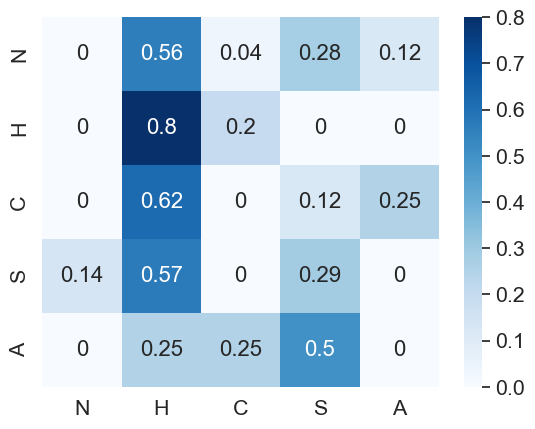

For model:  RF  matrix is:
Metric : ACC, Score :  0.74
Metric : TP_Rate, Score :  0.36
Metric : FP_Rate, Score :  0.16
Metric : Precision, Score :  0.36
Metric : F_Measure, Score :  0.36
Metric : F_Micro, Score :  0.33
Metric : F_Macro, Score :  0.29
Confusion Matrix: 
      N     H     C     S     A
N  0.17  0.17  0.22  0.33  0.11
H  0.00  0.55  0.27  0.18  0.00
C  0.00  0.12  0.50  0.25  0.12
S  0.00  0.00  0.40  0.60  0.00
A  0.14  0.00  0.14  0.71  0.00


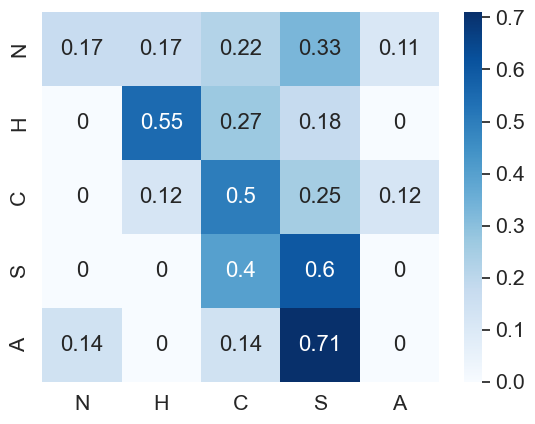

For model:  XGB  matrix is:


C:\Users\dekassla\AppData\Local\Temp\ipykernel_20820\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.77
Metric : TP_Rate, Score :  0.43
Metric : FP_Rate, Score :  0.14
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.59
Metric : F_Macro, Score :  0.40
Confusion Matrix: 
      N     H     C     S    A
N  0.76  0.21  0.03  0.00  0.0
H  0.25  0.75  0.00  0.00  0.0
C  0.80  0.00  0.20  0.00  0.0
S  0.43  0.00  0.14  0.43  0.0
A  1.00  0.00  0.00  0.00  0.0


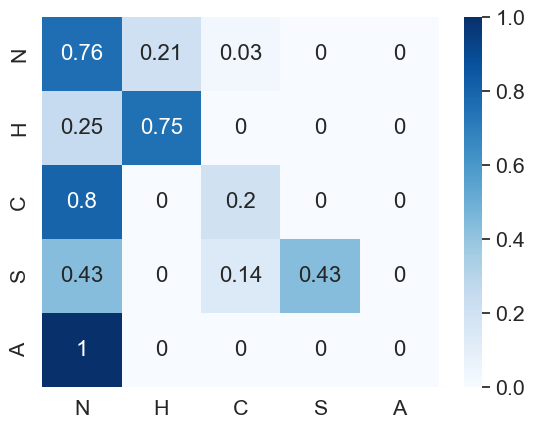

For model:  SVM  matrix is:
Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.49
Metric : F_Macro, Score :  0.13
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


C:\Users\dekassla\AppData\Local\Temp\ipykernel_20820\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


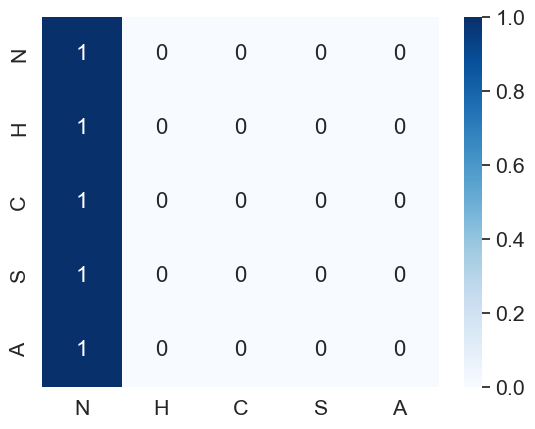

For model:  MLP  matrix is:


D:\Coding_Projects\erkd\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Metric : ACC, Score :  0.66
Metric : TP_Rate, Score :  0.15
Metric : FP_Rate, Score :  0.21
Metric : Precision, Score :  0.03
Metric : F_Measure, Score :  0.06
Metric : F_Micro, Score :  0.39
Metric : F_Macro, Score :  0.12
Confusion Matrix: 
      N     H     C     S     A
N  0.76  0.12  0.04  0.04  0.04
H  0.70  0.00  0.20  0.00  0.10
C  1.00  0.00  0.00  0.00  0.00
S  1.00  0.00  0.00  0.00  0.00
A  1.00  0.00  0.00  0.00  0.00


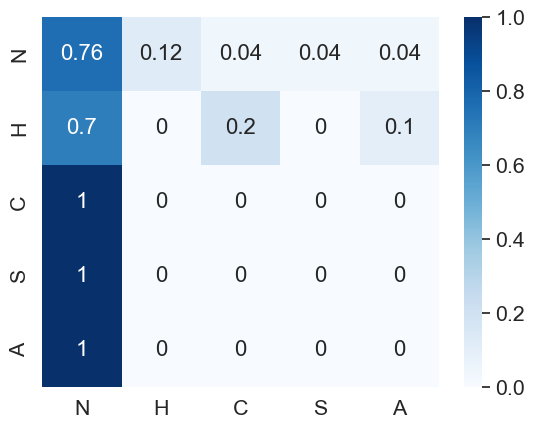

In [66]:
# run all probabilities

model_names = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

for model_name in model_names:
    print("For model: ", model_name, " matrix is:")
    iterate_all_models(model_name)

CNN

In [67]:
#comment out
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()

### Binary classification

In [68]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.683 0.101
0.68 0.102
0.658 0.12


Class H:
0.844 0.071
0.637 0.144
0.358 0.286


Class C:
0.86 0.045
0.512 0.108
0.067 0.133


Class S:
0.848 0.05
0.576 0.108
0.2 0.163


Class A:
0.901 0.02
0.574 0.126
0.15 0.189


In [69]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1})
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.579 0.072
0.498 0.115
0.963 0.053


Class H:
0.853 0.057
0.627 0.135
0.281 0.214


Class C:
0.813 0.062
0.541 0.108
0.227 0.253


Class S:
0.8 0.125
0.621 0.137
0.383 0.202


Class A:
0.886 0.032
0.558 0.128
0.215 0.324


In [70]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.669 0.112
0.648 0.128
0.542 0.259


Class H:
0.852 0.019
0.46 0.006
0.0 0.0


Class C:
0.872 0.011
0.466 0.003
0.0 0.0


Class S:
0.868 0.014
0.465 0.004
0.0 0.0


Class A:
0.902 0.019
0.474 0.005
0.0 0.0


### predict values

In [71]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle

# Assuming your preprocessing steps and model loading functions are defined
# Load the CSV file
df = pd.read_csv('data/fixed_dummy_dataset.csv')

# Select a single row (for example, the first row for simplicity)
sample_row = df.iloc[0:1]

# Preprocess the sample_row
# Convert categorical features into numerical features


# Use .loc to safely modify the DataFrame slice
sample_row.loc[:, 'gender'] = (sample_row['gender'] == 'Male').astype(int)
sample_row.loc[:, 'ageRange'] = sample_row['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
sample_row.loc[:, 'degree'] = sample_row['degree'].map({'High School': 1, 'College/University': 2})
sample_row.loc[:, 'pcTimeAverage'] = sample_row['pcTimeAverage'].map({'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
sample_row.loc[:, 'status'] = sample_row['status'].map({'Student': 1, 'Professional': 2})
sample_row.loc[:, 'typeWith'] = sample_row['typeWith'].map({'1 hand': 1, '2 hands': 2})

# Check if 'country' and 'typistType' columns exist before creating dummies
if 'country' in sample_row.columns and 'typistType' in sample_row.columns:
    sample_row = pd.get_dummies(sample_row, columns=['country', 'typistType'])
else:
    print("Columns 'country' and/or 'typistType' do not exist in the DataFrame.")
    
print("now df: ", sample_row)

# Assuming 'emotion' is the label column in your CSV
actual_emotion = sample_row['emotionIndex'].values[0]  # Save the actual emotion for comparison
sample_row = sample_row.drop('emotionIndex', axis=1)  # Drop the label column for prediction

print("after dropping emotion:", sample_row)

# Scale the data
scaler = MinMaxScaler()
sample_row_scaled = scaler.fit_transform(sample_row)

# Load your model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Predict the emotion
predicted_emotion = model.predict(sample_row_scaled)

# Print out the predicted and actual emotion for comparison
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Actual Emotion: {actual_emotion}")

Columns 'country' and/or 'typistType' do not exist in the DataFrame.
now df:     D1D2_mean  D1D2_std  D1U1_mean  D1U1_std  D1U2_mean  D1U2_std  TotTime  \
0        709       100      982.0        50      764.0        80      300   

   U1D2_mean  U1D2_std  U1U2_mean  ...  country_Italy  country_Portugal  \
0     -273.0       110     -218.0  ...              0                 0   

   country_Spain  country_Suisse  country_Tunisia  \
0              0               0                1   

   country_United Arab Emirates  country_United_States  \
0                             0                      0   

   typistType_One Finger Typist  typistType_Touch Typist  \
0                             0                        1   

   typistType_Two Finger Typist  
0                             0  

[1 rows x 41 columns]


D:\Coding_Projects\erkd\.venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


KeyError: 'emotionIndex'

In [74]:
# note to self: you first have to conduct a cell running the iterate all method, to save model correctly
# Predict the emotion from a CSV file
for model in model_names:
    predictions = predict_emotion('data/fixed_dummy_dataset.csv', f'{model}.pkl')
    print(predictions)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
[[0.03782758 0.79564905 0.06350072 0.03218988 0.07083277]
 [0.14546951 0.46228476 0.19012041 0.09204794 0.11007738]
 [0.56071929 0.12619163 0.11090542 0.07760427 0.12457939]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[[0.38514716 0.3363903  0.13062076 0.12614026 0.02170152]
 [0.38550269 0.21776844 0.1248135  0.19373756 0.07817781]
 [0.40501642 0.17515556 0.18037879 0.17136153 0.0680877 ]]
<class 'xgboost.sklearn.XGBClassifier'>
[[0.08156225 0.80377096 0.08632693 0.01959585 0.00874393]
 [0.33594045 0.34363395 0.02827624 0.24714267 0.04500668]
 [0.7816793  0.07327123 0.01145149 0.12517619 0.00842184]]
<class 'sklearn.svm._classes.SVC'>
[[0.57434823 0.11921117 0.11256157 0.1155478  0.07833123]
 [0.52846465 0.14687325 0.127893   0.12140166 0.07536743]
 [0.52255642 0.15314696 0.12567826 0.12488233 0.07373603]]
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
[[5.72779812e-02 7.28712634e-01 1.029

In [76]:
#predict real csv
# Save the first 5 rows of the dataframe `data_fixed` to a CSV file
data_fixed.head(5).to_csv('data/data_fixed_first_5_rows.csv', index=False)

In [79]:
for model in model_names:
    predictions = predict_emotion('data/data_fixed_first_5_rows.csv', f'{model}.pkl')
    print(predictions)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
[[0.37636716 0.43217129 0.14159678 0.01920415 0.03066063]
 [0.13197919 0.69391566 0.09532928 0.01652823 0.06224764]
 [0.04894588 0.20157134 0.5565921  0.05949076 0.13339992]
 [0.04472421 0.41987217 0.36728634 0.13204799 0.03606929]
 [0.02874062 0.33911226 0.44864564 0.10791259 0.07558888]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[[0.40934004 0.15541864 0.09762968 0.30021301 0.03739863]
 [0.58309674 0.1695556  0.09698019 0.11488986 0.03547761]
 [0.42625604 0.20137161 0.1635602  0.14653745 0.0622747 ]
 [0.28344025 0.21417635 0.19823405 0.24685727 0.05729209]
 [0.49428547 0.30331096 0.06918404 0.07095815 0.06226139]]
<class 'xgboost.sklearn.XGBClassifier'>
[[0.52506804 0.28154156 0.02436922 0.13169976 0.03732144]
 [0.5865269  0.27689242 0.02914543 0.09327547 0.01415974]
 [0.61394423 0.22142166 0.04678061 0.10738056 0.01047297]
 [0.19624619 0.08908769 0.01662097 0.69343334 0.00461184]
 [0.20194674 0.7370776  0.01

## Feature importance

In [ ]:
# data standardization
scaler = MinMaxScaler()
data_fixed = pd.DataFrame(scaler.fit_transform(data_fixed), columns=data_fixed.columns)

#### Chi-squared

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

demo_features = np.array(
    ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status', 'country', 'typistType'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_fixed.loc[:, demo_features].fillna(100).replace(-1, 16),
               pd.cut(data_fixed.D1U2_mean.fillna(0), bins=[0, 372, 445, 573, 4306], labels=[1, 2, 3, 4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

#### Correlation coefficients

In [ ]:
importances = data_fixed.apply(lambda x: x.corr(data_fixed.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [ ]:
from info_gain import info_gain

importances_ig = []
for col in data_fixed.columns:
    importances_ig.append(info_gain.info_gain(data_fixed[col], data_fixed.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_fixed.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

#### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_fixed, data_fixed.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_fixed.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, 1)
fit = rfe.fit(data_fixed, label_fixed)

print("Feature Ranking: %s" % fit.ranking_)

In [ ]:
list(data_fixed.columns[fit.ranking_ - 1])

#### SHAP values

In [ ]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_fixed, columns=data_fixed.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=len(data_fixed.columns))

#### RF feature importance

In [ ]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

In [ ]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()